In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import recall_score, precision_score, f1_score, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import shap
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/60_percent.csv')

In [3]:
df.head()

,image_name,sl_1,sl_2,sl_3,sl_4,sl_5,sl_6,sl_7,sl_8,sl_9,sl_10,sl_11,sl_12,target
0,Image00429.tif,65115.0,32773.0,16362.0,8290.0,4036.0,2002.0,1082.0,542.0,288.0,110.0,64.0,39.0,1.0
1,Image00401.tif,64454.0,30959.0,15571.0,8169.0,4168.0,2168.0,1192.0,634.0,321.0,179.0,106.0,75.0,1.0
2,Image00367.tif,64529.0,32588.0,16270.0,8271.0,4126.0,2029.0,1059.0,557.0,293.0,144.0,78.0,36.0,1.0
3,Image00373.tif,62288.0,31563.0,16181.0,8344.0,4216.0,2200.0,1126.0,611.0,339.0,170.0,96.0,56.0,1.0
4,Image00415.tif,59363.0,29562.0,15047.0,8077.0,4376.0,2522.0,1411.0,875.0,491.0,290.0,177.0,101.0,1.0


In [4]:
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
    """Function for data preprocessing."""
    try:
        data.drop('image_name', axis=1, inplace=True)
    except:
        pass
    
    data.target = data.target.astype(int)
    
    X, y = data.drop('target', axis=1), data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.35, random_state=1)
    
    scaler = StandardScaler()
    X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
def plot_importance(model, data: pd.DataFrame):
    """Function for plot feature importance."""
    explainer = shap.Explainer(model)
    shap_values = explainer(data.drop('target', axis=1))
    shap_importance = shap_values.abs.mean(0).values
    sorted_idx = shap_importance.argsort()
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(data.drop('target', axis=1).columns)[sorted_idx])
    plt.title('SHAP Importance')
    plt.show()

In [6]:
def show_metrics(y_test, predict):
    print(f'F1 score: {f1_score(y_test, predict):.3f}')
    print(f'Precision score: {precision_score(y_test, predict):.3f}')
    print(f'Recall score: {recall_score(y_test, predict):.3f}')

In [7]:
X_train, X_test, y_train, y_test = preprocessing(df)

## XGB without hyperparametrs

In [8]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [9]:
show_metrics(y_test, predict)

F1 score: 0.541
Precision score: 0.629
Recall score: 0.474


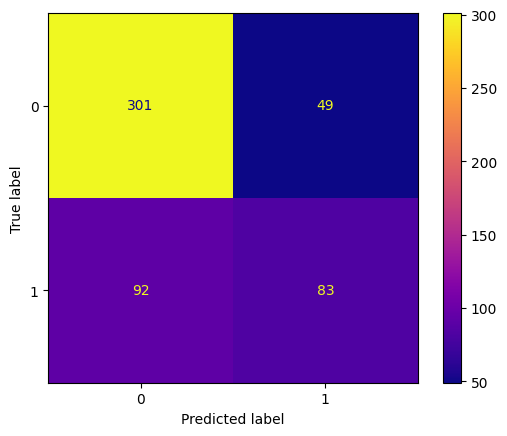

In [10]:
plot_confusion_matrix(model, X_test, y_test, cmap='plasma')

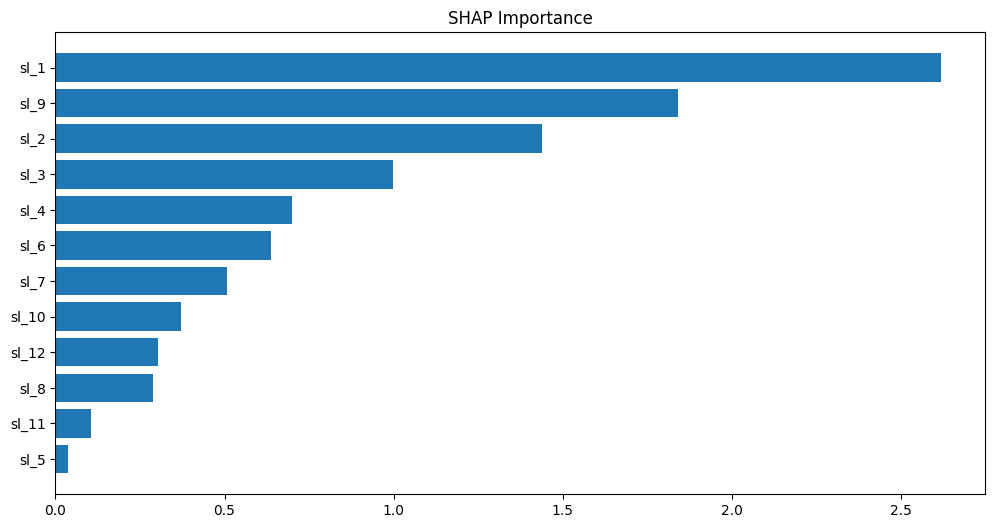

In [11]:
plot_importance(model, df)

## XGB HyperTuning

In [12]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'booster': ['gbtree', 'gblinear'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

In [13]:
xgb_gs_cv = GridSearchCV(
    xgb.XGBClassifier(n_jobs=-1), 
    params, n_jobs=-1, 
    cv=KFold(n_splits=5), 
    scoring='roc_auc'
)

xgb_gs_cv.fit(X_train, y_train)

print(f'Best score: {xgb_gs_cv.best_score_}')
print(f'Best params: {xgb_gs_cv.best_params_}')

Best score: 0.6838147361392821
Best params: {'base_score': 0.5, 'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 5}


In [14]:
model_tuned = xgb.XGBClassifier(**xgb_gs_cv.best_params_)
model_tuned.fit(X_train, y_train)
predict_tuned = model_tuned.predict(X_test)

In [15]:
show_metrics(y_test, predict_tuned)

F1 score: 0.521
Precision score: 0.695
Recall score: 0.417


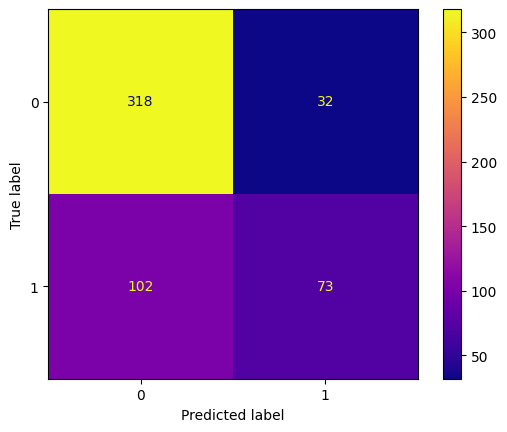

In [16]:
plot_confusion_matrix(model_tuned, X_test, y_test, cmap='plasma')

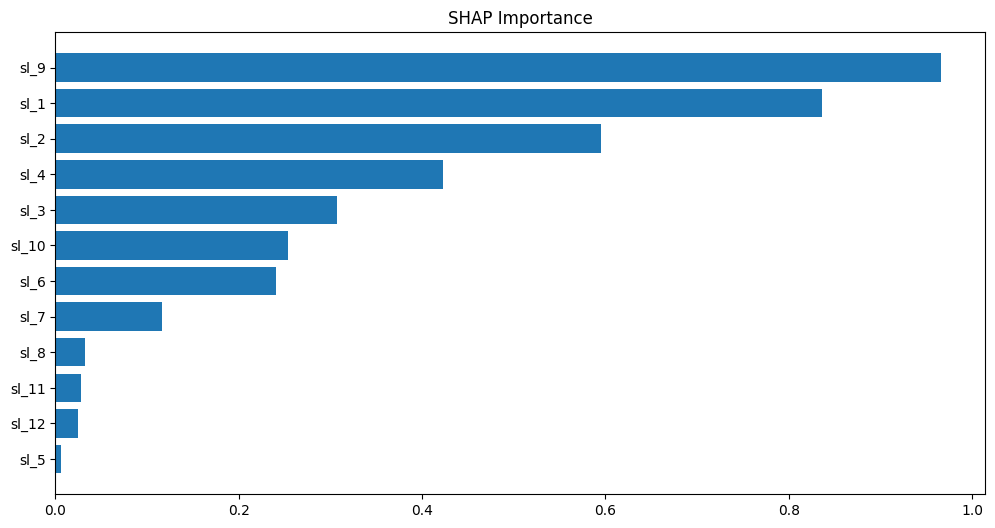

In [17]:
plot_importance(model_tuned, df)

Возьмем 6 наиболее информативных признаков и обучим модель с подобранными гиперпараметрами, далее посмотрим, как изменятся значения наших метрик

In [18]:
df = df[['sl_9', 'sl_1', 'sl_2', 'sl_4', 'sl_3', 'sl_10', 'target']]

In [19]:
X_train, X_test, y_train, y_test = preprocessing(df)

In [20]:
model = xgb.XGBClassifier(**xgb_gs_cv.best_params_)
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [21]:
show_metrics(y_test, predict)

F1 score: 0.576
Precision score: 0.777
Recall score: 0.457


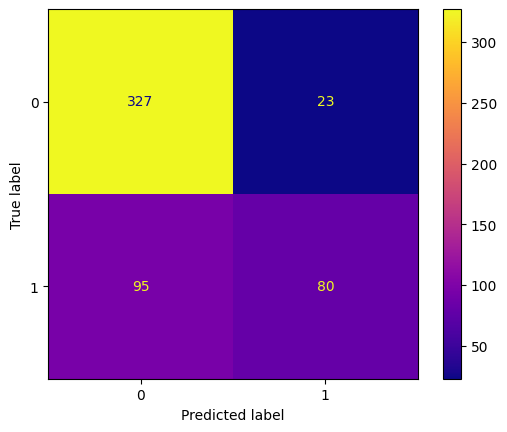

In [22]:
plot_confusion_matrix(model, X_test, y_test, cmap='plasma')

Качество улучшилось после отбора 6-ти признаков, что Recall стал лучше, что Precision, далее посмотрим на качество в зависимости от заполненности контейнера.

In [23]:
Q = []
F1 = []
percentages = [15, 30, 45, 60, 75, 90]

In [24]:
for percent in tqdm(percentages, colour='GREEN'):
    df = pd.read_csv(f'../data/{percent}_percent.csv')
    X_train, X_test, y_train, y_test = preprocessing(df)
    
    model = xgb.XGBClassifier(**xgb_gs_cv.best_params_)
    model.fit(X_train, y_train)
    predict = model_tuned.predict(X_test)
    
    Q.append(percent)
    F1.append(f1_score(y_test, predict))

  0%|          | 0/6 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

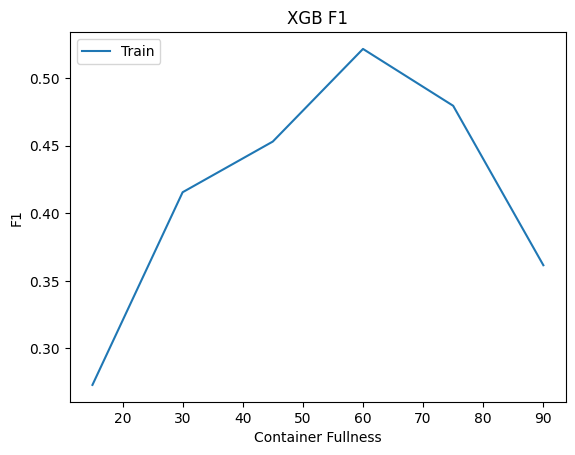

In [25]:
plt.plot(Q, F1)
plt.title('XGB F1')
plt.xlabel('Container Fullness')
plt.ylabel('F1')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Качество ML модели росло до заполненности контейнера равным в 60, далее мы видим, что F1 резко начала падать вниз, данный момент требует дополнительного исследования...